In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
from scipy.stats import median_abs_deviation
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv; load_dotenv()
import ipynbname
import shutil
import os

from upsetplot import UpSet, from_indicators


# Hyperparamyters
BASE_PATH = os.getenv("BASE_PATH_FOR_SAVING")
DISEASE_TYPE = "diseased" # diseased / healthy
SAMPLE_ID = "sample_01"
BCL = "240805_SL-EXD_0328_B22FKKYLT4"
LIBRARY = "SI-TT-H3"

# 1. Make raw adata object
## 1.1 Copy data from Google Bucket to here
```bash
    # slide tags counts (not used) + metadata (x,y)
        # copy in: .../DISEASE_TYPE/SAMPLE_ID/BCL/LIBRARY/slide_tags
    gsutil cp gs://fc-secure-d99fbd65-eb27-4989-95b4-4cf559aa7d36/slide-tags/251027_SL-EXD_0706_A233KGFLT4/SI-TT-H1/seurat.qs  .

    # cell bender counts
        # copy in: .../DISEASE_TYPE/SAMPLE_ID/BCL/LIBRARY/cellbender
    gsutil cp gs://fc-secure-d99fbd65-eb27-4989-95b4-4cf559aa7d36/cellbender-outs/251027_SL-EXD_0706_A233KGFLT4/SI-TT-H1/SI-TT-H1_out_filtered.h5 .../cellbender/
```
## 1.2 Install: R dependecies, R, qs library
Needed to convert .qs file into h5ad
- Install R dependencies
```bash
sudo apt-get install -y \
    build-essential \
    libhdf5-dev \
    libzstd-dev \
    liblz4-dev \
    libxxhash-dev \
    libcurl4-openssl-dev \
    libssl-dev \
    libxml2-dev \
    zlib1g-dev
```

- Install R
```bash
sudo apt-get install r-base r-base-dev
 ```

- install qs library
 ```R
install.packages("qs")
 ```

# 2. Extract metadata (x,y) from slidetags .qs file

In [2]:
cwd = os.getcwd()
print(cwd)
slide_tags_folder = f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/{BCL}/{LIBRARY}/slide_tags/"

%cd {slide_tags_folder}

/home/gdallagl/myworkdir/XDP/script/single_sample_analysis
/home/gdallagl/myworkdir/data/XDP/diseased/sample_01/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-H3/slide_tags


In [3]:
%%bash
R --vanilla << 'EOF'
library(qs)

# Read the Seurat object
seurat <- qread("./seurat.qs")

# Extract and save just the metadata
metadata <- seurat@meta.data
write.csv(metadata, "./seurat_metadata.csv", row.names = TRUE)

bash: line 9: warning: here-document at line 1 delimited by end-of-file (wanted `EOF')



R version 4.5.2 (2025-10-31) -- "[Not] Part in a Rumble"
Copyright (C) 2025 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(qs)


qs 0.27.3. Announcement: https://github.com/qsbase/qs/issues/103


> 
> # Read the Seurat object
> seurat <- qread("./seurat.qs")
> 
> # Extract and save just the metadata
> metadata <- seurat@meta.data
> write.csv(metadata, "./seurat_metadata.csv", row.names = TRUE)
> 


In [4]:
%cd {cwd}

/home/gdallagl/myworkdir/XDP/script/single_sample_analysis


# 3. Create adata obj

- metadata --> from slidetags
- count matrix --> from cell bender

- use cells present in both

In [5]:
# 1. Load CellBender cleaned counts
adata_cb = sc.read_10x_h5(f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/{BCL}/{LIBRARY}/cellbender/{LIBRARY}_out_filtered.h5")
print(adata_cb)

# 2. Load Slidetag metadata
metadata_slidetags = pd.read_csv(f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/{BCL}/{LIBRARY}/slide_tags/seurat_metadata.csv").rename(columns={"Unnamed: 0": "barcode"})
display(metadata_slidetags)


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 36660 × 38606
    var: 'gene_ids', 'feature_types', 'genome'


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,barcode,orig.ident,nCount_RNA,nFeature_RNA,is_cell,pct_intronic,pct_mt,RNA_snn_res.0.8,seurat_clusters,x,y,dbscan_clusters,dbscan_score
0,AAACCAAAGAACAGAC-1,Slide-tags,7751,3549,True,0.582893,0.002322,6,6,36750.336875,-4918.947027,1,0.914737
1,AAACCAAAGAATATCC-1,Slide-tags,20694,5933,True,0.676476,0.000435,18,18,6546.427751,-8964.535170,1,0.949614
2,AAACCAAAGAGTCGTC-1,Slide-tags,18435,4892,True,0.712612,0.000814,4,4,45734.792830,8427.068976,1,0.978896
3,AAACCAAAGATCCCAA-1,Slide-tags,5812,2740,True,0.686855,0.001893,8,8,51201.227539,525.607101,1,0.960045
4,AAACCAAAGCAAGCGA-1,Slide-tags,4154,2069,True,0.672605,0.001685,8,8,8939.060270,5043.015355,1,0.973961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37763,GTTGTGGGTACGTGAT-1,Slide-tags,1659,1145,True,0.671489,0.001808,1,1,7312.232149,5689.570899,1,0.790263
37764,GTTGTGGGTAGGCATT-1,Slide-tags,5322,2493,True,0.751973,0.000939,20,20,11313.567114,8499.633020,1,0.966612
37765,GTTGTGGGTATCGTGG-1,Slide-tags,18468,6073,True,0.610678,0.003303,5,5,31393.199291,-120.827487,1,0.963507
37766,GTTGTGGGTCATACCC-1,Slide-tags,3201,1715,True,0.691346,0.000625,0,0,46188.098628,-7745.600240,1,0.903554


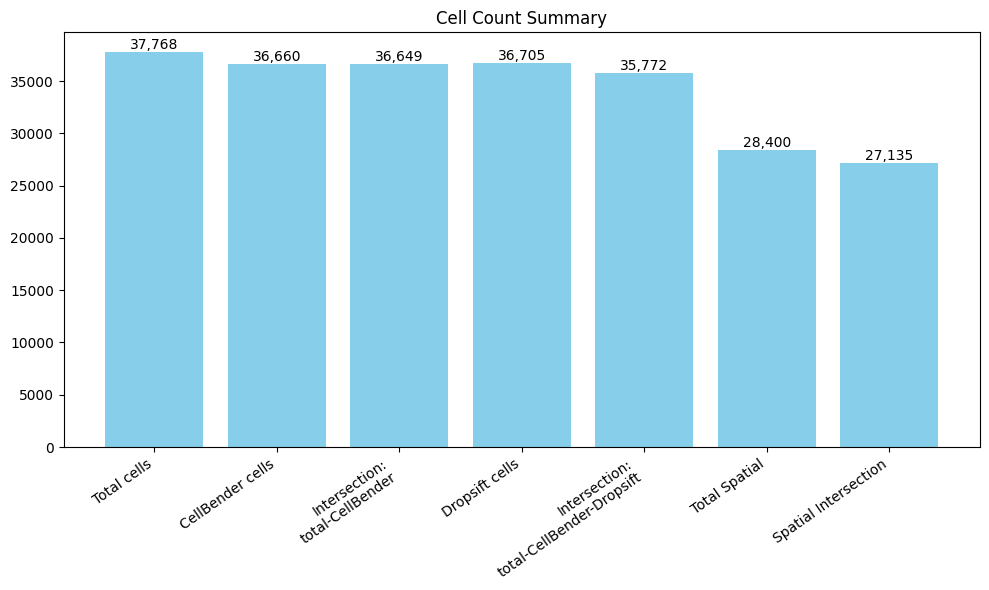

In [6]:
# cells 
# Sets of cells
cellbender_cells = set(adata_cb.obs_names)
slidetags_cells = set(metadata_slidetags["barcode"])

# Intersection of CellBender + SlideTags
intersection_cells_slidetags_cellbender = cellbender_cells.intersection(slidetags_cells)

# SlideTags cells filtered by DropSift
slidetags_cells_by_dropsift = set(metadata_slidetags[metadata_slidetags.is_cell == True]["barcode"])

# Intersection of CellBender + DropSift-filtered SlideTags
intersection_cells_slidetags_cellbender_dropsift = cellbender_cells.intersection(slidetags_cells_by_dropsift)

# Cells with spatial information (DBSCAN cluster == 1)
cells_with_spatial = set(metadata_slidetags[metadata_slidetags.dbscan_clusters == 1]["barcode"])

# Intersection of (CellBender + SlideTags + Dropsift) with spatial cells
intersection_cells_with_spatial = intersection_cells_slidetags_cellbender_dropsift.intersection(cells_with_spatial)

data = {
    'Total cells': slidetags_cells,
    'CellBender cells': cellbender_cells,
    'Intersection:\ntotal-CellBender': intersection_cells_slidetags_cellbender,
    'Dropsift cells': slidetags_cells_by_dropsift,
    'Intersection:\ntotal-CellBender-Dropsift': intersection_cells_slidetags_cellbender_dropsift,
    'Total Spatial': cells_with_spatial,
    'Spatial Intersection': intersection_cells_with_spatial
}

# 2. Extract values (handles integers or lists/sets automatically)
counts = [len(x) if hasattr(x, '__len__') else x for x in data.values()]
labels = list(data.keys())

# 3. Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color='skyblue')

plt.bar_label(bars, fmt='{:,.0f}') # Automatically adds labels on top
plt.xticks(rotation=35, ha='right')
plt.title('Cell Count Summary')
plt.tight_layout()
plt.show()

In [7]:
# make adata obj

# Subset CellBender AnnData to intersection
adata = adata_cb[sorted(intersection_cells_slidetags_cellbender)].copy()

# Subset slidetag metadata to the same cells
    # .loc[adata.obs_names] explicitly indexes by adata.obs_names in the exact same order
metadata_intersection = metadata_slidetags.set_index("barcode").loc[adata.obs_names]
assert (metadata_intersection.index == adata.obs_names).all(), "Index mismatch!"

# Add slidetag metadata into AnnData obs
adata.obs = adata.obs.join(metadata_intersection)

# Change var names as MapMyCell wokrs wiht emsableID
adata.var['gene_symbol'] = adata.var.index # Save current index (gene symbols) to a new column
adata.var.set_index('gene_ids', inplace=True) # Set the 'gene_ids' column as the new index
adata.var.index.name = 'ensembl_id' #rename the index

print(adata)
display(adata.obs)
display(adata.var)

AnnData object with n_obs × n_vars = 36649 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'is_cell', 'pct_intronic', 'pct_mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'x', 'y', 'dbscan_clusters', 'dbscan_score'
    var: 'feature_types', 'genome', 'gene_symbol'


/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,orig.ident,nCount_RNA,nFeature_RNA,is_cell,pct_intronic,pct_mt,RNA_snn_res.0.8,seurat_clusters,x,y,dbscan_clusters,dbscan_score
AAACCAAAGAACAGAC-1,Slide-tags,7751,3549,True,0.582893,0.002322,6,6,36750.336875,-4918.947027,1,0.914737
AAACCAAAGAATATCC-1,Slide-tags,20694,5933,True,0.676476,0.000435,18,18,6546.427751,-8964.535170,1,0.949614
AAACCAAAGAGTCGTC-1,Slide-tags,18435,4892,True,0.712612,0.000814,4,4,45734.792830,8427.068976,1,0.978896
AAACCAAAGATCCCAA-1,Slide-tags,5812,2740,True,0.686855,0.001893,8,8,51201.227539,525.607101,1,0.960045
AAACCAAAGCAAGCGA-1,Slide-tags,4154,2069,True,0.672605,0.001685,8,8,8939.060270,5043.015355,1,0.973961
...,...,...,...,...,...,...,...,...,...,...,...,...
GTTGTGGGTACGTGAT-1,Slide-tags,1659,1145,True,0.671489,0.001808,1,1,7312.232149,5689.570899,1,0.790263
GTTGTGGGTAGGCATT-1,Slide-tags,5322,2493,True,0.751973,0.000939,20,20,11313.567114,8499.633020,1,0.966612
GTTGTGGGTATCGTGG-1,Slide-tags,18468,6073,True,0.610678,0.003303,5,5,31393.199291,-120.827487,1,0.963507
GTTGTGGGTCATACCC-1,Slide-tags,3201,1715,True,0.691346,0.000625,0,0,46188.098628,-7745.600240,1,0.903554


,feature_types,genome,gene_symbol
ensembl_id,,,
ENSG00000290825,Gene Expression,GRCh38,DDX11L2
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG
ENSG00000237613,Gene Expression,GRCh38,FAM138A
ENSG00000290826,Gene Expression,GRCh38,ENSG00000290826
ENSG00000186092,Gene Expression,GRCh38,OR4F5
...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,ENSG00000277836
ENSG00000278633,Gene Expression,GRCh38,ENSG00000278633
ENSG00000276017,Gene Expression,GRCh38,ENSG00000276017


In [8]:
# Check 1: Shape (cells × genes)
print(f"Shape: {adata.shape}")  # Should be (n_cells, n_genes)

# Check 2: Are counts integers/raw?
print(f"Max value: {adata.X.max()}")  # Should be reasonable count values
print(f"Data type: {adata.X.dtype}")  # Should be integer-like

# Check 3: Gene IDs are Ensembl?
print(adata.var.index[:5])  # Should start with 'ENSG' for human

# Check 4: No NaN or negative values
print(f"Contains NaN: {pd.isna(adata.X.data).any()}")  # Should be False
print(f"Min value: {adata.X.min()}")  # Should be >= 0

# Check 5: Duplicate gene IDs
gene_duplicates = adata.var.index.duplicated()
n_gene_duplicates = gene_duplicates.sum()
print(f"Duplicate genes: {n_gene_duplicates}")
if n_gene_duplicates > 0:
    print(f"⚠️  Duplicate gene IDs found: {adata.var.index[gene_duplicates].tolist()[:10]}")



Shape: (36649, 38606)
Max value: 17660
Data type: int64
Index(['ENSG00000290825', 'ENSG00000243485', 'ENSG00000237613',
       'ENSG00000290826', 'ENSG00000186092'],
      dtype='object', name='ensembl_id')
Contains NaN: False
Min value: 0
Duplicate genes: 0


# 4. Remove no more correct metadata

As we use the count matrix from cell bender, some QC metrics calculated from slidetags are no more correct.

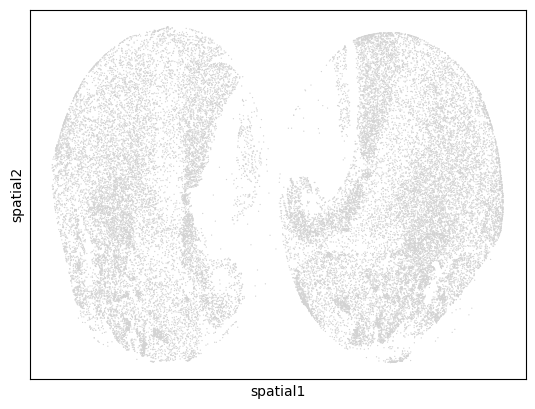

AnnData object with n_obs × n_vars = 36649 × 38606
    obs: 'x', 'y', 'pct_intronic', 'is_cell', 'dbscan_clusters', 'dbscan_score', 'has_spatial'
    var: 'feature_types', 'genome', 'gene_symbol'
    obsm: 'spatial'
    layers: 'counts'

In [9]:
# Remove qc metric columns that are no more correct after using cell itersection
    # ATTNETION: pct_intronic --> not totally correct, but lets leave it
adata.obs = adata.obs[["x", "y", "pct_intronic", "is_cell", "dbscan_clusters", "dbscan_score"]]

# Add spatila data
adata.obs["has_spatial"] = (~adata.obs.x.isna()) & (~adata.obs.x.isna()) & (adata.obs.dbscan_clusters == 1)
adata.obsm["spatial"] = adata.obs[["x","y"]].values
sc.pl.embedding(adata, basis="spatial")#, color="nCount_RNA")

# Save raw counts
adata.layers["counts"] = adata.X.copy()

display(adata)

# 4. Save

In [10]:
adata.write(f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/{BCL}/{LIBRARY}/adata/raw_adata.h5ad")

# 5. Save Notebook

In [11]:
# Get the notebook path
notebook_path = str(ipynbname.path())
print(f"Current notebook: {notebook_path}")

# Save it
base_name = os.path.basename(notebook_path).replace('.ipynb', '')  # Remove .ipynb
saving_path = f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/notebooks/{base_name}_{BCL}_{LIBRARY}.ipynb"
print(f"Saved to {saving_path}")

print("\n   Press Ctrl+S")

Current notebook: /home/gdallagl/myworkdir/XDP/script/single_sample_analysis/01_create_adata.ipynb
Saved to /home/gdallagl/myworkdir/data/XDP/diseased/sample_01/notebooks/01_create_adata_240805_SL-EXD_0328_B22FKKYLT4_SI-TT-H3.ipynb

   Press Ctrl+S


In [13]:
shutil.copy(notebook_path, saving_path)

'/home/gdallagl/myworkdir/data/XDP/diseased/sample_01/notebooks/01_create_adata_240805_SL-EXD_0328_B22FKKYLT4_SI-TT-H3.ipynb'